In [1]:
# Disabling any minor warmings and logs
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing necessary libraries
import h5py
import numpy as np
from numpy import concatenate

import pandas as pd
from pandas import read_csv, concat, DataFrame

from math import sqrt
import tensorflow as tf
from matplotlib import pyplot
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras import callbacks
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv1D, LSTM, GRU
from keras.callbacks import ModelCheckpoint, CSVLogger

Using TensorFlow backend.


In [3]:
# Importing the dataset along with some changes
data = read_csv("Dataset/household_power_consumption.csv",
                   parse_dates={'dt' : ['Date', 'Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan', '?'])


In [4]:
# Replacing the '?' median of the data
median_value = data.median()
data = data.fillna(median_value)

# Ensuring all dataset is in float
values = data.values
values = values.astype('float32')

In [5]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

In [6]:
print(scaled.head(3))

          0         1         2         3    4      5         6
0 -0.250407 -0.398561 -0.247819 -0.244813 -1.0 -0.975  0.096774
1 -0.043274 -0.372662 -0.326010 -0.053942 -1.0 -0.975  0.032258
2 -0.040739 -0.283453 -0.347981 -0.053942 -1.0 -0.950  0.096774


In [7]:
# Creating a timeseries function to convert the timeseries dataset
def timeseries_data(data, lookback=1, predicted_col=1):
    temp=data.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    
    predicted_value=data.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    return final_df

In [8]:
# Reframing the dataset
reframed_df= timeseries_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)
reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)','var1(t)']

In [9]:
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1   -0.250407  -0.398561  -0.247819  -0.244813       -1.0     -0.975   
2   -0.043274  -0.372662  -0.326010  -0.053942       -1.0     -0.975   
3   -0.040739  -0.283453  -0.347981  -0.053942       -1.0     -0.950   
4   -0.038204  -0.277698  -0.318901  -0.053942       -1.0     -0.975   

    var7(t-1)   var1(t)  
id                       
1    0.096774 -0.043274  
2    0.032258 -0.040739  
3    0.096774 -0.038204  
4    0.096774 -0.349991  


In [10]:
# Spliting the dataset into train and test sets
values = reframed_df.values
train_ = values[:, :-1]
labels = values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(train_, labels, test_size=0.27, random_state=0)

In [11]:
# Reshaping input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [12]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1514938, 1, 7) (1514938,) (560320, 1, 7) (560320,)


In [13]:
# Creating a model out of a sequential model and appending the LSTM layers for timeseries computations
batch_size = 34
epochs = 30
model = Sequential()
model.add(LSTM(20, batch_input_shape=(batch_size, 1, train_X.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(40, batch_input_shape=(batch_size, 1, train_X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Printing the model summary including parameters of the designed network
model.summary()

W0829 23:05:40.146209 140587367958144 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 23:05:40.159066 140587367958144 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 23:05:40.161573 140587367958144 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 23:05:40.670659 140587367958144 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (34, 1, 80)               28160     
_________________________________________________________________
lstm_2 (LSTM)                (34, 100)                 72400     
_________________________________________________________________
dense_1 (Dense)              (34, 1)                   101       
Total params: 100,661
Trainable params: 100,661
Non-trainable params: 0
_________________________________________________________________




Cycle: 1


W0829 23:05:41.003016 140587367958144 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0829 23:05:41.841569 140587367958144 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0829 23:05:42.017091 140587367958144 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1514938 samples, validate on 560320 samples
Epoch 1/30
1514938/1514938 [==============================] - 226s 149us/step - loss: 0.0036 - val_loss: 0.0027
Epoch 2/30
1514938/1514938 [==============================] - 274s 181us/step - loss: 0.0026 - val_loss: 0.0034
Epoch 3/30
1514938/1514938 [==============================] - 237s 156us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/30
1514938/1514938 [==============================] - 228s 151us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/30
1514938/1514938 [==============================] - 199s 131us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/30
1514938/1514938 [==============================] - 197s 130us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/30
1514938/1514938 [==============================] - 189s 124us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 8/30
1514938/1514938 [==============================] - 189s 125us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/30
1514938/1514938 [=======================

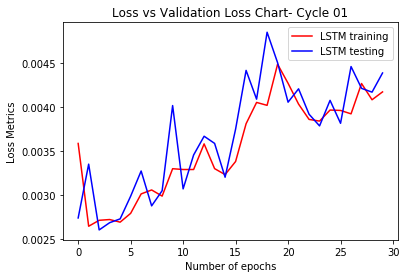



Cycle: 2
Train on 1514938 samples, validate on 560320 samples
Epoch 1/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0047 - val_loss: 0.0048
Epoch 2/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 3/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0053 - val_loss: 0.0055
Epoch 4/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 5/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0048 - val_loss: 0.0047
Epoch 6/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0045 - val_loss: 0.0043
Epoch 7/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/30
1514938/1514938 [============

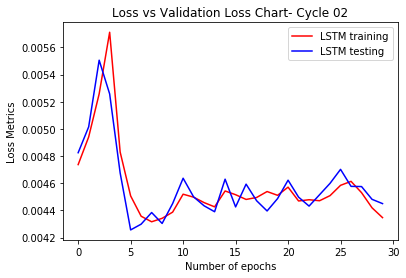



Cycle: 3
Train on 1514938 samples, validate on 560320 samples
Epoch 1/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 2/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 3/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 5/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 6/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 7/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 8/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/30
1514938/1514938 [============

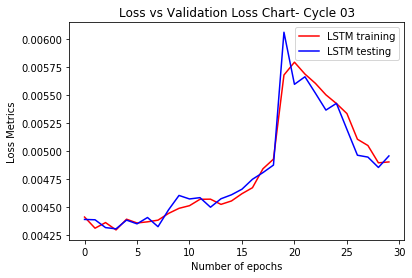



Cycle: 4
Train on 1514938 samples, validate on 560320 samples
Epoch 1/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 2/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0050 - val_loss: 0.0051
Epoch 3/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 4/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0051 - val_loss: 0.0052
Epoch 5/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0054 - val_loss: 0.0056
Epoch 6/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0057 - val_loss: 0.0058
Epoch 7/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 8/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/30
1514938/1514938 [============

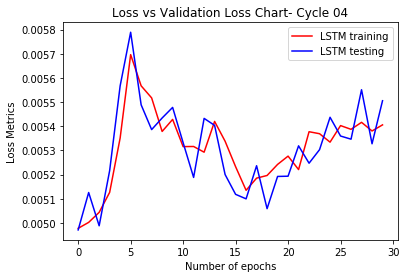



Cycle: 5
Train on 1514938 samples, validate on 560320 samples
Epoch 1/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0055 - val_loss: 0.0053
Epoch 2/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0054 - val_loss: 0.0054
Epoch 3/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0055 - val_loss: 0.0055
Epoch 4/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0055 - val_loss: 0.0055
Epoch 5/30
1514938/1514938 [==============================] - 181s 119us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 6/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0055 - val_loss: 0.0055
Epoch 7/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0055 - val_loss: 0.0054
Epoch 8/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/30
1514938/1514938 [============

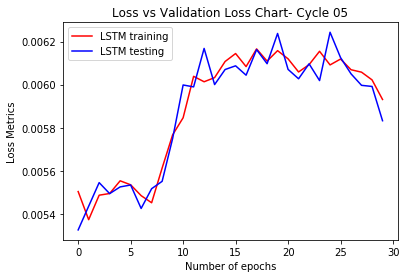



Cycle: 6
Train on 1514938 samples, validate on 560320 samples
Epoch 1/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0063 - val_loss: 0.0061
Epoch 2/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0062 - val_loss: 0.0062
Epoch 3/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0061 - val_loss: 0.0060
Epoch 4/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0058 - val_loss: 0.0060
Epoch 5/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0058 - val_loss: 0.0062
Epoch 6/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0063 - val_loss: 0.0062
Epoch 7/30
1514938/1514938 [==============================] - 182s 120us/step - loss: 0.0062 - val_loss: 0.0063
Epoch 8/30
1514938/1514938 [==============================] - 181s 120us/step - loss: 0.0059 - val_loss: 0.0057
Epoch 9/30
1514938/1514938 [============

KeyboardInterrupt: 

In [14]:
for i in range(10):
    print('\n\nCycle:',i+1)
    
    # Saving the model with every improvement in the accuracy
    checkpointer = callbacks.ModelCheckpoint(filepath=f'Model/checkpoint Cycle {i+1:02d}.hdf5', verbose=1, save_best_only=True, monitor='val_acc',mode='max')
    csv_logger = CSVLogger('Model/model.csv',separator=',', append=False)
    
    model_ = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                       validation_data=(test_X, test_y), shuffle=False, 
                       callbacks=[checkpointer,csv_logger])
    
    # Plotting/saving the graph on the loss and validation loss of the model throughout the training process
    pyplot.plot(model_.history['loss'], label='LSTM training', color='red')
    pyplot.plot(model_.history['val_loss'], label='LSTM testing', color= 'blue')
    pyplot.xlabel('Number of epochs')
    pyplot.ylabel('Loss Metrics')
    pyplot.title(f'Loss vs Validation Loss Chart- Cycle {i+1:02d}')
    pyplot.legend()
    pyplot.savefig(fname=f'Graph/loss chart- Cycle {i+1:02d}.png', dpi = 350)
    pyplot.show()
    
    model.reset_states()

In [15]:
# Saving the final model at the end of the training
model.save("Model/model.hdf5")
print("Final model saved successfully!")

Final model saved successfully!
